In [1]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers, models, Input
import tensorflow as tf


dataset_path = "data"
image_size = (192, 192)
unet_model_path = "Models/SegmentationModelUnet/model.keras"

dataset_path = "data"

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


In [2]:
def load_images_from_folder(folder_path, max_depth = 5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue
        

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, image_size)
                            img = img/255
                            images.append(img)
                            labels.append(1 if file[6]!='0' else 0)
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)

        else:
            del dirs[:]
    
    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")

    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")

Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 192, 192)


In [3]:
#Removing Bias towards Alcohol Detection

#Splitting Classes
alcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 1]
nonAlcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 0]

alcoholicClass = np.array(alcoholicClass)
nonAlcoholicClass = np.array(nonAlcoholicClass)

#Data Generator Setup
datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.025,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Augmentation:

n1 = len(nonAlcoholicClass)
n2 = len(alcoholicClass)
target_size = n2
augmentation_needed = target_size - n1

print(f'Number of samples in Class 1 (FFD): {n1}')
print(f'Number of samples in Class 2 (Alcoholic): {n2}')
print(f'Augmenting {augmentation_needed} images for Class 1 to match Class 2.')

augmented_images = []
for i in range(augmentation_needed):
    img = nonAlcoholicClass[i % n1]  
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)  
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_img = np.squeeze(augmented_img, axis=-1)
    augmented_img = augmented_img.astype(int)
    augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)

concagtedClassNon = np.concatenate([nonAlcoholicClass, augmented_images], axis=0)

print(f'New size of Class 1: {len(alcoholicClass)}')
print(f'New size of Class 2: {len(concagtedClassNon)}')

Number of samples in Class 1 (FFD): 580
Number of samples in Class 2 (Alcoholic): 2240
Augmenting 1660 images for Class 1 to match Class 2.
New size of Class 1: 2240
New size of Class 2: 2240


In [4]:
alcoholic_labels = np.ones(len(alcoholicClass))
nonAlcoholic_labels = np.zeros(len(concagtedClassNon))

images = np.concatenate([alcoholicClass, concagtedClassNon], axis=0)
labels = np.concatenate([alcoholic_labels, nonAlcoholic_labels], axis=0)

shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
labels = labels[shuffled_indices]

print(f"Total number of images after augmentation: {len(images)}")
print(f"Shape of final images array: {images.shape}")
print(f"Shape of final labels array: {labels.shape}")

Total number of images after augmentation: 4480
Shape of final images array: (4480, 192, 192)
Shape of final labels array: (4480,)


In [5]:
#Segmenting Images
print(images.shape)

unet_model = tf.keras.models.load_model(unet_model_path)
segmentedImages = unet_model.predict(images)

print(segmentedImages.shape)

(4480, 192, 192)
140/140 ━━━━━━━━━━━━━━━━━━━━ 129s 923ms/step
(4480, 192, 192, 1)


In [6]:
images = np.expand_dims(images, -1)
print(f"Images shape changed to: {images.shape}")

Images shape changed to: (4480, 192, 192, 1)


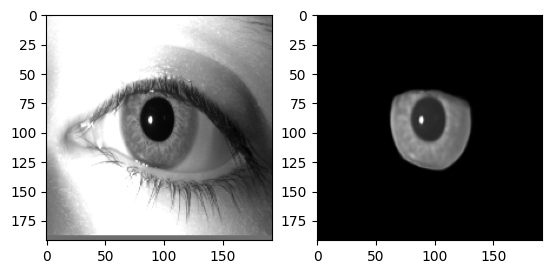

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(images[900], cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(segmentedImages[900], cmap='gray')
plt.show()

In [8]:
def attention_module(x):
    # Simple attention block (SE-style)
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(x.shape[-1] // 8, activation='relu')(se)
    se = layers.Dense(x.shape[-1], activation='sigmoid')(se)
    se = layers.Reshape((1, 1, x.shape[-1]))(se)
    return layers.Multiply()([x, se])

def feature_extraction_branch(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = attention_module(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    return models.Model(inp, x)

def fusion_classification_model(input_shape):
    input1 = Input(shape=input_shape, name='raw_input')
    input2 = Input(shape=input_shape, name='seg_input')

    branch = feature_extraction_branch(input_shape)

    feat1 = branch(input1)
    feat2 = branch(input2)

    # Fusion
    fused = layers.Concatenate()([feat1, feat2])
    fused = layers.Dense(64, activation='relu')(fused)
    fused = layers.Dropout(0.5)(fused)
    output = layers.Dense(1, activation='sigmoid')(fused)

    return models.Model(inputs=[input1, input2], outputs=output)


In [9]:
def attention_module(x):
    # Simple attention block (SE-style)
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(x.shape[-1] // 8, activation='relu')(se)
    se = layers.Dense(x.shape[-1], activation='sigmoid')(se)
    se = layers.Reshape((1, 1, x.shape[-1]))(se)
    return layers.Multiply()([x, se])

def feature_extraction_branch(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = attention_module(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    return models.Model(inp, x)

def fusion_classification_model(input_shape):
    input1 = Input(shape=input_shape, name='raw_input')
    input2 = Input(shape=input_shape, name='seg_input')

    branch = feature_extraction_branch(input_shape)

    feat1 = branch(input1)
    feat2 = branch(input2)

    # Fusion
    fused = layers.Concatenate()([feat1, feat2])
    fused = layers.Dense(64, activation='relu')(fused)
    fused = layers.Dropout(0.5)(fused)
    output = layers.Dense(1, activation='sigmoid')(fused)

    return models.Model(inputs=[input1, input2], outputs=output)


In [10]:
print(labels.shape)
lables = labels.astype("float32").reshape(-1, 1)
print(lables.shape)

(4480,)
(4480, 1)


In [11]:
images_train, images_test, segImages_train, segImages_test, labels_train, labels_test = train_test_split(images, segmentedImages, labels, test_size=0.7, random_state=23)

In [12]:
model = fusion_classification_model((192, 192, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.fit([images_train, segImages_train], labels_train, epochs=100, batch_size=32)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 253ms/step - accuracy: 0.7833 - loss: 0.6018
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.8735 - loss: 0.3456
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.8799 - loss: 0.3175
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.8678 - loss: 0.3348
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - accuracy: 0.8784 - loss: 0.3311
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.8761 - loss: 0.3239
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.8922 - loss: 0.3009
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.8890 - loss: 0.3029
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.8849 - loss: 0.3067
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.8783 - loss: 0.3079
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.8745 - loss: 0.3178
Epoch 12/100
42/42 ━━━━━━━━━━━

In [14]:
loss, accuracy = model.evaluate([images_test, segImages_test], labels_test)
print(f"CNN Test Accuracy: {accuracy * 100:.2f}%")

predictions = model.predict([images_test, segImages_test])
predicted_classes = (predictions > 0.5).astype(int).flatten()

report = classification_report(labels_test.flatten(), predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

print(f'Overall Accuracy: {accuracy * 100:.2f}%')

98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8637 - loss: 0.3311
CNN Test Accuracy: 86.77%
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step
              precision    recall  f1-score   support

Fit for Duty       1.00      0.74      0.85      1578
   Alcoholic       0.79      1.00      0.88      1558

    accuracy                           0.87      3136
   macro avg       0.89      0.87      0.87      3136
weighted avg       0.90      0.87      0.87      3136

Overall Accuracy: 86.77%
